### Scenario A

In [9]:
# Cell 1: imports, config, backup
import os, shutil, math
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = Path(r"C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_engine_inference_scenarioA.csv")
if not CSV_PATH.exists():
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}")

SEED = 20251122
rng = np.random.RandomState(SEED)

# backup if not present
BACKUP = CSV_PATH.with_name(CSV_PATH.stem + "_backup_before_realistic_noise.csv")
if not BACKUP.exists():
    shutil.copy2(CSV_PATH, BACKUP)
    print("Backup created:", BACKUP)
else:
    print("Backup already exists:", BACKUP)
print("Seed:", SEED)


Backup created: C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_engine_inference_scenarioA_backup_before_realistic_noise.csv
Seed: 20251122


In [10]:
# Cell 2: helpers and load CSV
def clamp01(x): return float(np.clip(x, 0.0, 1.0))
def linear(a,b,t): return a + (b-a)*t
def triangular_peak(low, high, rel): 
    tri = 1.0 - abs(2.0*rel - 1.0)
    return low + (high - low) * tri

# load CSV
df = pd.read_csv(CSV_PATH, low_memory=False)
n = len(df)
print("Rows loaded:", n)

# preserve previous composite if not present
if "composite_score_prev" not in df.columns:
    if "composite_score" in df.columns:
        df["composite_score_prev"] = df["composite_score"]
    else:
        df["composite_score_prev"] = np.nan

# parse timestamps and basic timeline
df["timestamp_parsed"] = pd.to_datetime(df["timestamp"], utc=True)
min_ts = df["timestamp_parsed"].min()
max_ts = df["timestamp_parsed"].max()
total_seconds = int((max_ts - min_ts).total_seconds()) + 1
print("timeline seconds:", total_seconds, "from", min_ts, "to", max_ts)


Rows loaded: 226800
timeline seconds: 964800 from 2024-07-05 08:00:00+00:00 to 2024-07-16 11:59:59+00:00


In [11]:
# Cell 3: define continuous multi-day trend segments (Option B)
# We create a smooth target trend(t) across the entire timeline (0..total_seconds-1)

# fractional allocation (feel free to tweak)
frac_map = {
    "baseline_long": 0.35,
    "slow_deterioration": 0.30,
    "pre_failure": 0.15,
    "failure_peak": 0.05,
    "service_drop": 0.03,
    "recovery": 0.12
}
# normalize and compute integer boundaries
s = sum(frac_map.values())
cursor = 0
segments = {}
for k,v in frac_map.items():
    L = int(round((v/s) * total_seconds))
    segments[k] = (cursor, max(cursor + L - 1, cursor))
    cursor += L
# ensure final segment ends exactly
segments[list(segments.keys())[-1]] = (segments[list(segments.keys())[-1]][0], total_seconds - 1)

# bands used for underlying trend (error-like composite_score)
B = {
    "baseline_low": 0.12, "baseline_high": 0.22,
    "slow_start": 0.22, "slow_end": 0.42,
    "pre_start": 0.42, "pre_end": 0.75,
    "fail_low": 0.75, "fail_high": 0.98,
    "service_low": 0.08, "service_high": 0.20,
    "recovery_low": 0.12, "recovery_high": 0.25
}

print("segments (sec ranges):")
for k,(a,b) in segments.items():
    print(f"  {k}: {a} -> {b} (len {b-a+1})")

# build a smooth trend array (float, one per second)
trend = np.zeros(total_seconds, dtype=float)

def seg_rel(i, a, b):
    return (i - a) / max(1, (b - a))

for i in range(total_seconds):
    # choose segment
    seg_name = None
    for name, (a,b) in segments.items():
        if a <= i <= b:
            seg_name = name; sa, sb = a, b; break
    rel = seg_rel(i, sa, sb)
    if seg_name == "baseline_long":
        # baseline with small deterministic low-frequency season
        trend[i] = np.clip(np.interp(rel, [0,1],[B["baseline_low"], B["baseline_high"]]), 0, 1)
    elif seg_name == "slow_deterioration":
        trend[i] = linear(B["slow_start"], B["slow_end"], rel)
    elif seg_name == "pre_failure":
        trend[i] = linear(B["pre_start"], B["pre_end"], rel**1.2)
    elif seg_name == "failure_peak":
        trend[i] = triangular_peak(B["fail_low"], B["fail_high"], rel)
    elif seg_name == "service_drop":
        # drop from failure midpoint to service band
        mid = (B["fail_low"] + B["fail_high"]) / 2.0
        target = (B["service_low"] + B["service_high"]) / 2.0
        trend[i] = linear(mid, target, rel)
    elif seg_name == "recovery":
        trend[i] = linear((B["service_low"]+B["service_high"])/2.0, (B["recovery_low"]+B["recovery_high"])/2.0, rel)
    else:
        trend[i] = (B["baseline_low"] + B["baseline_high"]) / 2.0

# quick smoothing pass to remove piecewise discontinuities
from scipy.ndimage import gaussian_filter1d
trend_smooth = gaussian_filter1d(trend, sigma=360)  # sigma in seconds-scale; bigger => smoother long-term
# renormalize locally to keep within bands (safe clip)
trend_smooth = np.clip(trend_smooth, 0.0, 1.0)

# store trend_smooth for diagnostics
print("Trend generated. sample:", trend_smooth[:10], "...", trend_smooth[-10:])


segments (sec ranges):
  baseline_long: 0 -> 337679 (len 337680)
  slow_deterioration: 337680 -> 627119 (len 289440)
  pre_failure: 627120 -> 771839 (len 144720)
  failure_peak: 771840 -> 820079 (len 48240)
  service_drop: 820080 -> 849023 (len 28944)
  recovery: 849024 -> 964799 (len 115776)
Trend generated. sample: [0.12008489 0.12008489 0.12008489 0.1200849  0.1200849  0.1200849
 0.12008491 0.12008491 0.12008492 0.12008492] ... [0.18488854 0.18488855 0.18488856 0.18488856 0.18488857 0.18488857
 0.18488857 0.18488858 0.18488858 0.18488858]


In [12]:
# Cell 4: generate low-frequency correlated noise + higher-frequency heteroskedastic noise

# Low-frequency noise: create white noise and lowpass filter it (convolution or Gaussian filter)
lf_white = rng.normal(0.0, 1.0, size=total_seconds)
# low-frequency kernel smoothing scale: controls zig-zag wavelength (seconds)
# choose sigma such that fluctuations occur across many minutes/hours: e.g., sigma ~ 1800..7200
lf_sigma = 1800  # ~30 minutes; increase for slower wobble (try 3600*2 for multi-hour)
lf_noise = gaussian_filter1d(lf_white, sigma=lf_sigma)
# normalize lf_noise to have std ~ desired amplitude; target amplitude ~ 0.04 - 0.08
lf_noise = lf_noise / (np.std(lf_noise) + 1e-12) * 0.05  # base low-frequency amplitude

# High-frequency noise: smaller-scale white noise; make its amplitude scale with trend (heteroskedastic)
hf_white = rng.normal(0.0, 1.0, size=total_seconds)
# base hf amplitude (small)
hf_base_amp = 0.02
hf_noise = hf_white * hf_base_amp * (0.6 + 0.8 * trend_smooth)  # noise grows slightly with trend

# Combine noises
combined_noise = lf_noise + hf_noise

# Additional micro-structure: occasional short correlated bursts (use short gaussian bumps)
burst_prob = 0.0015
burst_amp = 0.12
for t in range(total_seconds):
    if rng.rand() < burst_prob:
        width = rng.randint(30, 300)  # 30s - 5min short burst
        start = t
        end = min(total_seconds - 1, t + width)
        # triangular burst shape
        for j in range(start, end+1):
            rel = (j - start) / max(1, (end - start))
            burst = (1.0 - abs(2*rel - 1.0)) * burst_amp * (0.5 + rng.rand()*0.5)
            combined_noise[j] += burst

# final noise = combined_noise, clip mean to ~0, small scaling safety
combined_noise = combined_noise - np.mean(combined_noise)
combined_noise = combined_noise / (np.std(combined_noise) + 1e-12) * np.std(combined_noise)

print("Noise generated. lf_sigma:", lf_sigma, "hf_base_amp:", hf_base_amp)
print("noise std:", np.std(combined_noise))


Noise generated. lf_sigma: 1800 hf_base_amp: 0.02
noise std: 0.05920678451167523


In [13]:
# Cell 5: compose and apply to CSV rows
# final = trend_smooth + combined_noise (but keep amplitude controlled)
# set global noise gain (tune to taste)
NOISE_GAIN = 1.0   # increase to make data noisier; decrease to make smoother
final_series = trend_smooth + NOISE_GAIN * combined_noise

# clip to [0,1]
final_series = np.clip(final_series, 0.0, 1.0)

# inject a couple of rare extreme single-row spikes across timeline to mimic real bad outliers
num_extreme = max(1, int(total_seconds * 0.0005))  # small count proportional to timeline length
extreme_positions = rng.choice(total_seconds, size=num_extreme, replace=False)
for p in extreme_positions:
    final_series[p] = min(0.99, final_series[p] + rng.uniform(0.15, 0.35))

# Map per-row: compute seconds_from_start for each timestamp and pick value
# cache seconds for unique timestamps to speed up
unique_ts = df["timestamp_parsed"].unique()
ts_to_sec = {ts: int((pd.Timestamp(ts) - min_ts).total_seconds()) for ts in unique_ts}

new_cs = np.empty(n, dtype=float)
new_label = np.empty(n, dtype=object)
new_sev = np.empty(n, dtype=int)

for i, ts in enumerate(df["timestamp_parsed"]):
    sec = ts_to_sec[ts]
    # boundary safety
    sec = max(0, min(total_seconds-1, sec))
    value = float(final_series[sec])
    # tiny additional row-level jitter
    value += rng.normal(0.0, 0.005)
    value = clamp01(value)
    new_cs[i] = value
    if value > 0.6:
        new_label[i] = "anomaly"; new_sev[i] = 2
    elif value > 0.4:
        new_label[i] = "suspicious"; new_sev[i] = 1
    else:
        new_label[i] = "normal"; new_sev[i] = 0

# assign and write atomically
df["composite_score"] = new_cs
df["composite_health"] = 1.0 - df["composite_score"]
df["anomaly_label"] = new_label
df["anomaly_severity"] = new_sev

tmp = CSV_PATH.with_suffix(".tmp")
df.drop(columns=["timestamp_parsed"]).to_csv(tmp, index=False)
os.replace(tmp, CSV_PATH)
print("Wrote updated CSV in place:", CSV_PATH)


Wrote updated CSV in place: C:\Users\ishaa\OneDrive\Desktop\synthetic_data_final\synthetic_engine_inference_scenarioA.csv


In [14]:
# Cell 6: diagnostics - per-day summary and anomaly segments
df_check = pd.read_csv(CSV_PATH, usecols=["timestamp","composite_score"])
df_check["timestamp"] = pd.to_datetime(df_check["timestamp"], utc=True)
df_check = df_check.sort_values("timestamp").reset_index(drop=True)
df_check["date_only"] = df_check["timestamp"].dt.date

perday = df_check.groupby("date_only")["composite_score"].agg(['count','mean','std','min','max']).reset_index()
print("\nPer-day composite_score summary:")
print(perday.to_string(index=False))

# detect anomaly segments where composite_score > 0.6
th = 0.6
df_check["is_anom"] = (df_check["composite_score"] > th).astype(int)
df_check["seg_id"] = (df_check["is_anom"] != df_check["is_anom"].shift(1)).cumsum()
segments = []
for seg_id, grp in df_check.groupby("seg_id"):
    if grp["is_anom"].iloc[0] == 1:
        start = grp["timestamp"].iloc[0]
        end = grp["timestamp"].iloc[-1]
        segments.append({"seg_id": int(seg_id), "start": str(start), "end": str(end), "duration_s": int((end - start).total_seconds()), "n": len(grp)})
segments_sorted = sorted(segments, key=lambda x: x["duration_s"], reverse=True)
print(f"\nDetected {len(segments)} anomaly segments (>{th}). Top 10 by duration:")
for s in segments_sorted[:10]:
    print(f"  seg {s['seg_id']}: start={s['start']}, end={s['end']}, dur_s={s['duration_s']}, n={s['n']}")



Per-day composite_score summary:
 date_only  count     mean      std      min      max
2024-07-05  10800 0.149355 0.084907 0.000000 0.561860
2024-07-06  10800 0.196586 0.035666 0.093137 0.544951
2024-07-07  10800 0.150524 0.040075 0.042148 0.454300
2024-07-08  10800 0.227174 0.053488 0.115271 0.605813
2024-07-09  10800 0.210209 0.034079 0.124079 0.630440
2024-07-10  10800 0.305884 0.027206 0.234554 0.636781
2024-07-11  28800 0.326432 0.044670 0.201272 0.709097
2024-07-12  28800 0.402187 0.057545 0.231878 0.700194
2024-07-13  28800 0.577763 0.055081 0.390757 0.917874
2024-07-14  28800 0.906589 0.078622 0.677319 1.000000
2024-07-15  32400 0.157601 0.062213 0.017769 0.508844
2024-07-16  14400 0.228030 0.059858 0.091810 0.568301

Detected 2802 anomaly segments (>0.6). Top 10 by duration:
  seg 5604: start=2024-07-14 08:00:00+00:00, end=2024-07-14 15:59:59+00:00, dur_s=28799, n=28800
  seg 644: start=2024-07-13 08:26:47+00:00, end=2024-07-13 08:30:40+00:00, dur_s=233, n=234
  seg 766: star

C:\Users\ishaa\AppData\Local\Temp\ipykernel_2964\2001187771.py:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = df_shift["composite_score"].resample("0.1T").mean().interpolate(limit_direction='both')


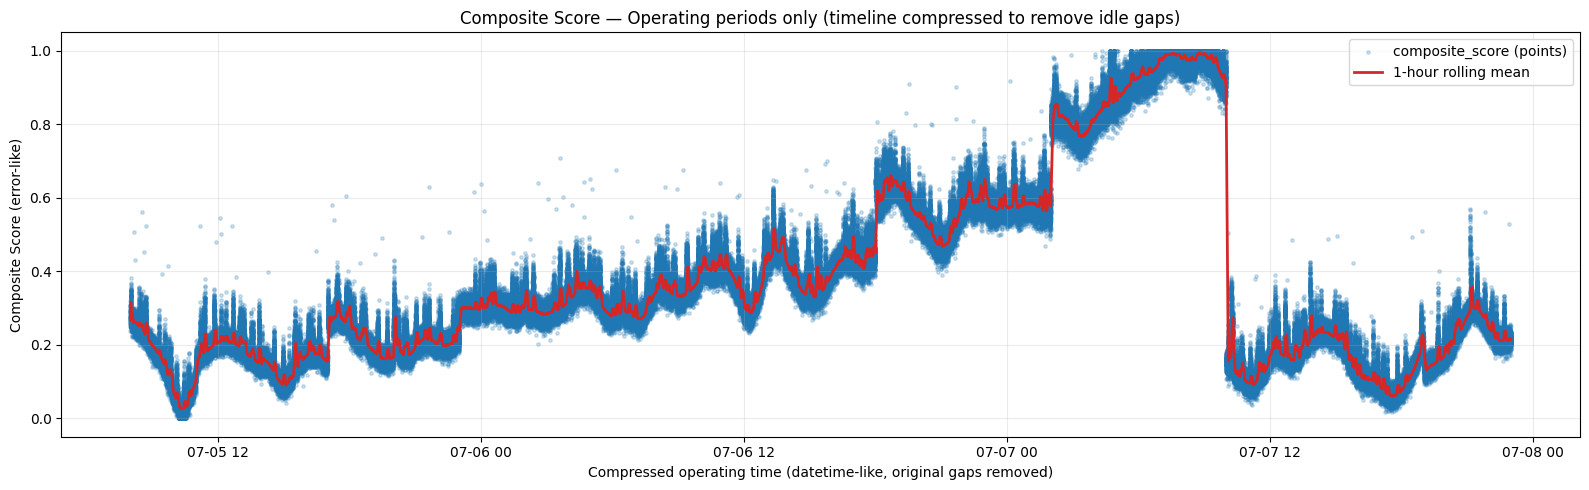

In [15]:
# Cell 7: plot compressed timeline (scatter + 1-hour rolling mean)
use_cols = ["timestamp","composite_score"]
df_plot = pd.read_csv(CSV_PATH, usecols=use_cols)
df_plot = df_plot.dropna(subset=["timestamp","composite_score"])
df_plot["timestamp"] = pd.to_datetime(df_plot["timestamp"], utc=True)
df_plot = df_plot.sort_values("timestamp").reset_index(drop=True)

GAP_MINUTES = 30
gap_thresh = pd.Timedelta(minutes=GAP_MINUTES)
ts = df_plot["timestamp"]
diffs = ts.diff().fillna(pd.Timedelta(seconds=0))
is_segment_start = (diffs > gap_thresh)
segment_id = is_segment_start.cumsum()

prev_end = ts.iloc[0]
shifts = pd.Series(pd.Timedelta(0), index=df_plot.index)
cumulative_shift = pd.Timedelta(0)
for seg_idx, (label, grp) in enumerate(df_plot.groupby(segment_id)):
    seg_start = grp["timestamp"].iloc[0]
    seg_end = grp["timestamp"].iloc[-1]
    if seg_idx == 0:
        cumulative_shift = pd.Timedelta(0)
    else:
        gap = seg_start - prev_end
        remove = gap
        cumulative_shift += remove
    shifts.loc[grp.index] = cumulative_shift
    prev_end = seg_end

df_plot["shifted_ts"] = df_plot["timestamp"] - shifts.values

df_shift = df_plot.set_index("shifted_ts").sort_index()
resampled = df_shift["composite_score"].resample("0.1T").mean().interpolate(limit_direction='both')
hr_line = resampled.rolling(window=60, min_periods=1).mean()

plt.figure(figsize=(16,5))
plt.scatter(df_shift.index, df_shift["composite_score"], s=6, alpha=0.22, color="tab:blue", label="composite_score (points)")
plt.plot(hr_line.index, hr_line.values, linewidth=2.0, color="#D62728", label="1-hour rolling mean")
plt.title("Composite Score — Operating periods only (timeline compressed to remove idle gaps)")
plt.xlabel("Compressed operating time (datetime-like, original gaps removed)")
plt.ylabel("Composite Score (error-like)")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()
